In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import kagglehub
import os


/home/harry/Documents/MIT/NEPSE/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Downloading the Financial Dataset from kaggle

# Download latest version
path = kagglehub.dataset_download("sbhatti/financial-sentiment-analysis")

print("Path to dataset files:", (path))

Path to dataset files: /home/harry/.cache/kagglehub/datasets/sbhatti/financial-sentiment-analysis/versions/4


In [4]:
df = pd.read_csv(f'{path}/data.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.shape

(5842, 2)

In [6]:
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

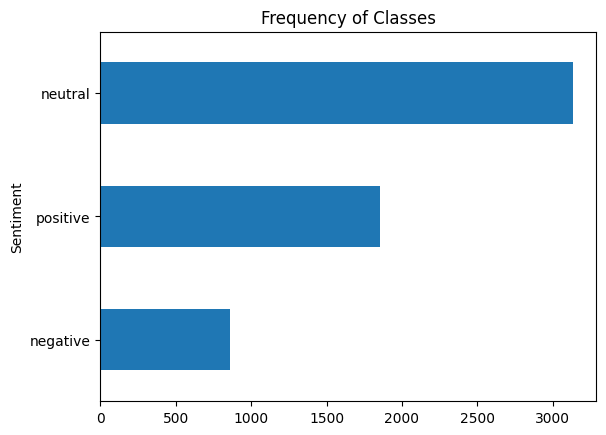

In [7]:
# looking at the class distribution

import matplotlib.pyplot as plt

df['Sentiment'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of Classes')
plt.show()

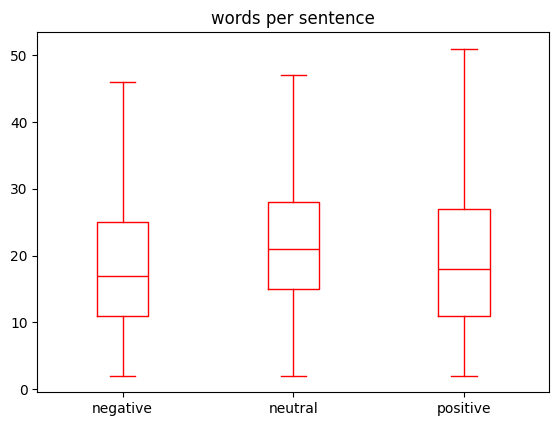

In [8]:
df['words per sentence'] = df['Sentence'].str.split().apply(len)
df.boxplot('words per sentence',by ='Sentiment',grid=False,showfliers=False,color='red')

plt.suptitle("")
plt.xlabel("")
plt.show()

In [9]:
df['label'] = df['Sentiment'].apply(lambda x: 0 if x == 'neutral' else 1 if x == 'positive' else -1 if x=='negative' else None)
df['label']

0       1
1      -1
2       1
3       0
4       0
       ..
5837   -1
5838    0
5839    0
5840    0
5841    1
Name: label, Length: 5842, dtype: int64

In [11]:
import spacy
import re

# Load the English language model
nlp = spacy.load("en_core_web_sm")

# Custom contraction mapping
CONTRACTION_MAP = {
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'ve": " have",
    "'m": " am",
    "it's": "it is",
    "that's": "that is"
}

def fix_contractions(text):
    for contraction, expansion in CONTRACTION_MAP.items():
        text = text.replace(contraction, expansion)
    return text

def preprocess_financial_text(text, keep_negs=True, keep_numbers=True, keep_currency=True):
    """
    Preprocess financial text with special handling for:
    - Currency symbols and amounts ($, Rs, NPR)
    - Nepali news content (basic handling)
    - Financial terminology preservation
    """
    
    # Expand contractions
    text = fix_contractions(text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Special handling for financial amounts before tokenization
    if keep_currency:
        # Normalize currency representations
        text = re.sub(r'\$(\d+\.?\d*)', r'dollar_\1', text)  # $100 → dollar_100
        text = re.sub(r'(\d+\.?\d*)\s?dollars?', r'dollar_\1', text, flags=re.IGNORECASE)
        text = re.sub(r'Rs\.?\s?(\d+\.?\d*)', r'rupee_\1', text)  # Rs 100 → rupee_100
        text = re.sub(r'NPR\s?(\d+\.?\d*)', r'npr_\1', text)  # NPR 100 → npr_100
    
    # Process with spaCy
    doc = nlp(text)
    
    processed_tokens = []
    for token in doc:
        if token.is_space:
            continue
            
        # Keep currency terms as single tokens
        if keep_currency and token.text.lower() in ['$', 'rs', 'npr', 'dollar', 'rupee']:
            processed_tokens.append(token.text.lower())
            continue
            
        # Handle punctuation - keep only certain financial-relevant punctuation
        if token.is_punct and token.text not in ['%', '.']:  # Keep percentage and decimal points
            continue
            
        # Handle numbers based on parameter
        if not keep_numbers and token.like_num:
            continue
            
        # Handle stop words with negation preservation
        if token.is_stop and not (keep_negs and token.lower_ in ["not", "no", "never", "nor"]):
            continue
            
        # Lemmatization
        lemma = token.lemma_.lower().strip()
        
        # Special handling for financial terms
        if lemma in ['stock', 'share', 'price', 'market']:  # Don't lemmatize these
            lemma = token.text.lower()
            
        if lemma:
            processed_tokens.append(lemma)
    
    return " ".join(processed_tokens)


df['cleaned_sentences'] = df['Sentence'].apply(preprocess_financial_text)

In [13]:
# Save the DataFrame to a CSV file
df.to_csv('../data/english_dataset.csv', index=False)

In [13]:
df.head()

,Sentence,Sentiment,label,cleaned_sentences
0,The GeoSolutions technology will leverage Bene...,positive,1,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,-1,$ esi low dollar_1.50 dollar_2.50 bk real poss...
2,"For the last quarter of 2010 , Componenta 's n...",positive,1,quarter 2010 componenta net sale double eur131...
3,According to the Finnish-Russian Chamber of Co...,neutral,0,accord finnish russian chamber commerce major ...
4,The Swedish buyout firm has sold its remaining...,neutral,0,swedish buyout firm sell remain 22.4 percent s...


In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("",model="ProsusAI/finbert")

OSError: There was a specific connection error when trying to load ProsusAI/finbert:
401 Client Error: Unauthorized for url: https://huggingface.co/ProsusAI/finbert/resolve/main/config.json (Request ID: Root=1-687cee22-31cb53843858d2187eb7dc72;800c2fd6-00db-4392-9787-5c95122e78c1)

Invalid credentials in Authorization header

In [ ]:
#Import necessary  libraries 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report



In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df['cleaned_sentences'],df['label'],test_size=0.2,random_state=18,stratify=df['label'])

In [ ]:
X_train.shape

(4673,)

In [ ]:
y_test.value_counts()

label
 0    626
 1    371
-1    172
Name: count, dtype: int64

# Using Naive Byes MultinomialNB

In [ ]:
from sklearn.pipeline import Pipeline

NB = Pipeline([
    ('tfidf',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [ ]:
NB.fit(X_train,y_train)

,steps,"[('tfidf', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [ ]:
y_pred = NB.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.43      0.41      0.42       172
           0       0.73      0.79      0.76       626
           1       0.71      0.62      0.66       371

    accuracy                           0.68      1169
   macro avg       0.62      0.61      0.61      1169
weighted avg       0.68      0.68      0.68      1169



# Using Random Forest

In [ ]:
from sklearn.pipeline import Pipeline

RF = Pipeline([
    ('vectorizer',CountVectorizer()),
    ('rf',RandomForestClassifier(n_estimators=50,criterion='entropy'))
])

In [ ]:
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.17      0.12      0.14       172
           0       0.65      0.80      0.72       626
           1       0.77      0.58      0.66       371

    accuracy                           0.63      1169
   macro avg       0.53      0.50      0.51      1169
weighted avg       0.62      0.63      0.62      1169



# Using KNN

In [ ]:
from sklearn.pipeline import Pipeline

KNN = Pipeline([
    ('tfidf',CountVectorizer(
        max_features=5000,      # Keep top 5000 words
        ngram_range=(1, 2),     # Use unigrams + bigrams
        min_df=2,)),
    ('knn',KNeighborsClassifier(n_neighbors=35,metric='cosine'))
])

In [ ]:
KNN.fit(X_train,y_train)
y_pred = KNN.predict(X_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.53      0.16      0.25       172
           0       0.67      0.90      0.76       626
           1       0.63      0.46      0.53       371

    accuracy                           0.65      1169
   macro avg       0.61      0.51      0.51      1169
weighted avg       0.63      0.65      0.61      1169



In [ ]:
from huggingface_hub import login
login(token="")

from transformers import AutoTokenizer, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")


/home/harry/Documents/MIT/NEPSE/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ImportError: 
AutoModelForSequenceClassification requires the PyTorch library but it was not found in your environment. Check out the instructions on the
installation page: https://pytorch.org/get-started/locally/ and follow the ones that match your environment.
Please note that you may need to restart your runtime after installation.


In [1]:
!pip install scikit-learn transformers

In [2]:
from googletrans import Translator

# Create a Translator object
translator = Translator()

# Translate text
translated = translator.translate('hello my name is hari', src='en', dest='ne')

# Access the translated text
print(translated)


<coroutine object Translator.translate at 0x7fd75e4a3040>


In [5]:
from googletrans import Translator

# Create a Translator object
translator = Translator()

# Translate text from English to Spanish
translated = translator.translate('Hello, how are you?', src='en', dest='es')

# Print the translated text
print(translated.text)  # Output: "Hola, ¿cómo estás?"


/tmp/ipykernel_12698/1570492935.py:7: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  translated = translator.translate('Hello, how are you?', src='en', dest='es')


AttributeError: 'coroutine' object has no attribute 'text'

In [7]:
! pip uninstall googletrans
! pip install googletrans==4.0.0-rc1


Found existing installation: googletrans 4.0.2
Uninstalling googletrans-4.0.2:
  Would remove:
    /home/harry/Documents/MIT/NEPSE/.venv/bin/translate
    /home/harry/Documents/MIT/NEPSE/.venv/lib/python3.13/site-packages/googletrans-4.0.2.dist-info/*
    /home/harry/Documents/MIT/NEPSE/.venv/lib/python3.13/site-packages/googletrans/*
Proceed (Y/n)? ERROR: Operation cancelled by user
^C
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.8 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17455 sha256=f65770cf9004882c0e0610b3a57e1122ed73bc6bb322cc2973d3ca85185cb021
  Stored in directory: /home/harry/.cache/pip/wheels/79/4e/93/807caa936897ff772ae263e9f39eb1d4878ef21e2d4c45a2a3
Successfully built googletrans
  Attempting uninstall: hyperframe
    Found existing installation: hyperframe 6.1.0
    Uni

In [9]:
import asyncio
from googletrans import AsyncTranslator

async def translate_text():
    # Create an AsyncTranslator object
    translator = AsyncTranslator()

    # Translate text from English to Spanish
    translated = await translator.translate('Hello, how are you?', src='en', dest='es')

    # Print the translated text
    print(translated.text)  # Output: "Hola, ¿cómo estás?"

# Run the asynchronous function
asyncio.run(translate_text())


ImportError: cannot import name 'AsyncTranslator' from 'googletrans' (/home/harry/Documents/MIT/NEPSE/.venv/lib/python3.13/site-packages/googletrans/__init__.py)

/home/harry/Documents/MIT/NEPSE/.venv/lib/python3.13/site-packages/pygments/regexopt.py:78: RuntimeWarning: coroutine 'Translator.translate' was never awaited
  for group in groupby(strings, lambda s: s[0] == first[0])) \
